# Predicting Churn for Interconnect Telecom Customers

#### Project Goals
1. To explore the role of:
    * contract variables such as contract type, billing method, and total and monthly charges
    * demographic variables such as gender, Senior Citizen status, relationship status, and dependents
    * internet service, add-ons, and multiple phone lines
    
    on customer churn and loyalty. 
2. To discover patterns that affect or predict customer churn in addition to identifying factors that are correlated with customer loyalty. *We want to understand what kind of customers leave Interconnect and identify patterns in loyal customers*.
3. To produce graphs and plots visualizing the information above.
4. To test different classification models using evaluation metrics such as AUC-ROC to identify models that can best predict churn.
5. Relay findings to Interconnect in a conclusion report to inform customer retention efforts.

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [2]:
contract = pd.read_csv("/datasets/final_provider/contract.csv")
personal = pd.read_csv("/datasets/final_provider/personal.csv")
internet = pd.read_csv("/datasets/final_provider/internet.csv")
phone = pd.read_csv("/datasets/final_provider/phone.csv")

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract['EndDate'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> Good deriving the target.
<a class="tocSkip"></a>

In [5]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,0,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,0,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,0,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,1,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Step 1

Exploring the effect of contract variables such as contract type, paperless billing, billing method (monthly or yearly), and total and monthly charges on churn rate and length of time as an Interconnect customer.

In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 440.3+ KB


We have 7,043 customer records. Let us look at how many customers have left, and how many have remained with Interconnect's Telecoms services.

Before we do this, we must change the BeginDate and EndDate columns that are listed as objects to datetime, and convert TotalCharges column to float type to match MonthlyCharges.

In [10]:
#converting Date columns to datetime format
# contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], errors='coerce')
# contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

#converting TotalCharges to float type
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['TotalCharges'].fillna(contract['TotalCharges'].median(), inplace=True)

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 440.3+ KB


In [12]:
#counting rows of cancelations i.e. where EndDate is not 'No'
cancelations = contract[contract['EndDate'] != 0]
cancelations.shape[0]

1869

In [13]:
customers = contract[contract['EndDate'] == 0]
len(customers)

5174

Out of the 7,043 Interconnect customers we have data on, 1,869 have canceled and are no longer subscribed to one of Interconnect's services. This amounts to 26.5% of the customers who have canceled, leaving us with 5,174 customers who remain subscribed to one of the company's services. 
Now we can begin to explore the connection between cancelations and contract type, billing, and customer charges. 

We will start by exploring whether canceled customers are more likely to be on monthly or annual plans. One would expect monthly plan customers to be far more likely to cancel and experience shorter tenures than those on yearly contracts but we will let the data confirm this.  

##### Exploring Contract Type on Cancelations

In [14]:
display(cancelations)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,3668-QPYBK,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15
4,9237-HQITU,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,1,Month-to-month,Yes,Electronic check,99.65,820.50
8,7892-POOKP,2017-07-01,1,Month-to-month,Yes,Electronic check,104.80,3046.05
13,0280-XJGEX,2015-09-01,1,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30
...,...,...,...,...,...,...,...,...
7021,1699-HPSBG,2018-11-01,1,One year,Yes,Electronic check,59.80,727.80
7026,8775-CEBBJ,2019-02-01,1,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35
7032,6894-LFHLY,2019-10-01,1,Month-to-month,Yes,Electronic check,75.75,75.75
7034,0639-TSIQW,2014-03-01,1,Month-to-month,Yes,Credit card (automatic),102.95,6886.25


At first glance, we see that 9 out of 10 of the cancelations on our sample list were on month to  month billing cycles, with all 10 customers on paperless billing. Given the overrepresentation of monthly and paperless billing among canceled customers, these two factors in particular are highly correlated with future cancelations. We will explore this further, beginning with contract type. 

In [15]:
customers[customers['Type'] == 'Month-to-month'].shape[0]

2220

2,220 of our 5,174 remaining customers are on month to month billing cycles. This amounts to just under 43% of all customers. 

In [16]:
cancelations[cancelations['Type'] == 'Month-to-month'].shape[0]

1655

1,655 of the 1,869 canceled customers were on monthly billing cycles! This amounts to a hair under 89% of our canceled customer base. 

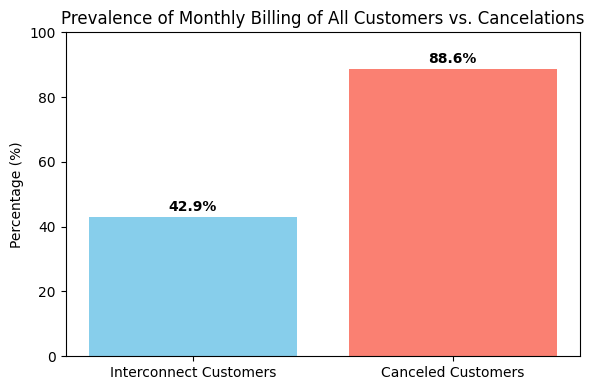

In [17]:
total_customers = len(customers)

# % on Month-to-Month billing
pct_month_to_month = (customers['Type'] == 'Month-to-month').sum() / total_customers * 100

# % that have canceled (EndDate != 'No')
pct_canceled = (cancelations['Type'] == 'Month-to-month').sum() / cancelations.shape[0] * 100

# Create chart
labels = ['Interconnect Customers', 'Canceled Customers']
values = [pct_month_to_month, pct_canceled]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['skyblue', 'salmon'])
plt.ylabel('Percentage (%)')
plt.title('Prevalence of Monthly Billing of All Customers vs. Cancelations')
plt.ylim(0, 100)

# Add percentage labels above bars
for i, val in enumerate(values):
    plt.text(i, val + 2, f"{val:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

###### **Finding #1: Canceled customers are more than twice as likely as current customers to be on month to month billing cycles**

In [18]:
print("\n")

##### Exploring how Paperless Billing is related to Cancelations

In [19]:
customers[customers['PaperlessBilling'] == 'Yes'].shape[0]

2771

2,771 of our 5,174 customers selected paperless billing. This amounts to ~54% of current Interconnect customers we have data for.

In [20]:
cancelations[cancelations['PaperlessBilling'] == 'Yes'].shape[0]

1400

1,400 of our 1,869 canceled customers were on paperless billing. This amounts to ~75% of all canceled customers.  

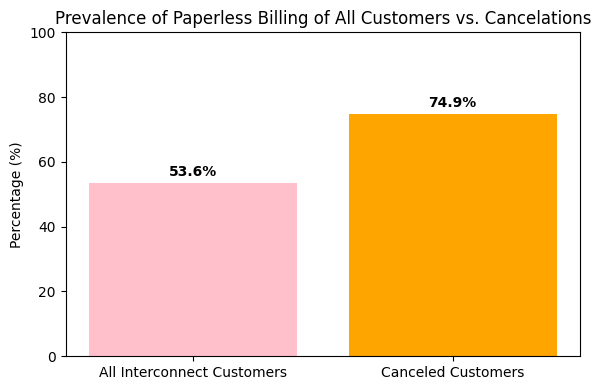

In [21]:
total_customers = len(customers)

# % on Month-to-Month billing
pct_paperless = (customers['PaperlessBilling'] == 'Yes').sum() / total_customers * 100

# % that have canceled (EndDate != 'No')
pct_canceled_paperless = (cancelations['PaperlessBilling'] == 'Yes').sum() / cancelations.shape[0] * 100

# Create chart
labels = ['All Interconnect Customers', 'Canceled Customers']
values = [pct_paperless, pct_canceled_paperless]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['pink', 'orange'])
plt.ylabel('Percentage (%)')
plt.title('Prevalence of Paperless Billing of All Customers vs. Cancelations')
plt.ylim(0, 100)

# Add percentage labels above bars
for i, val in enumerate(values):
    plt.text(i, val + 2, f"{val:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

###### **Finding #2: Canceled customers are 40% more likely to be on paperless billing than the current Interconnect customer**

In [22]:
print("\n")

##### Exploring the Relationship between Payment Method and Cancelations

In [23]:
payment_counts = customers['PaymentMethod'].value_counts()

In [24]:
payment_df = payment_counts.to_frame().reset_index()
payment_df.columns = ['PaymentMethod', 'CustomerCount']

# Calculate percentage
total_customers = len(customers)
payment_df['Percentage'] = (payment_df['CustomerCount'] / total_customers) * 100

#rounding percentages
payment_df['Percentage'] = payment_df['Percentage'].round(2)

display(payment_df)

,PaymentMethod,CustomerCount,Percentage
0,Mailed check,1304,25.20
1,Electronic check,1294,25.01
2,Credit card (automatic),1290,24.93
3,Bank transfer (automatic),1286,24.86


Electronic checks is the most common payment method for current Interconnect customers. We will compare this to the payment methods used by canceled customers. 

In [25]:
canceled_payment_counts = cancelations['PaymentMethod'].value_counts()

In [26]:
payment_df2 = canceled_payment_counts.to_frame().reset_index()
payment_df2.columns = ['PaymentMethod', 'CustomerCount']

# Calculate percentage
total_customers = len(cancelations)
payment_df2['Percentage'] = (payment_df2['CustomerCount'] / total_customers) * 100

#rounding percentages
payment_df2['Percentage'] = payment_df2['Percentage'].round(2)

display(payment_df2)

,PaymentMethod,CustomerCount,Percentage
0,Electronic check,1071,57.30
1,Mailed check,308,16.48
2,Bank transfer (automatic),258,13.80
3,Credit card (automatic),232,12.41


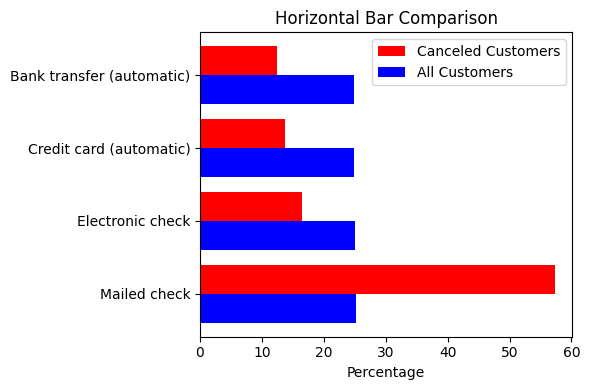

In [27]:
plt.figure(figsize=(6, 4))
y = np.arange(len(payment_df))
plt.barh(y + 0.2, payment_df2['Percentage'], height=0.4, label='Canceled Customers', color='red')
plt.barh(y - 0.2, payment_df['Percentage'], height=0.4, label='All Customers', color='blue')
plt.yticks(y, payment_df['PaymentMethod'])
plt.xlabel('Percentage')
plt.title('Horizontal Bar Comparison')
plt.legend()
plt.tight_layout()
plt.show()

###### **Finding #3: Canceled customers are:**
###### - **32% more likely to be on Electronic check billing than the average Interconnect customer**
###### - **13% less likely to pay by credit card, 10% less likely to pay by bank transfer, and 9% less likely to pay by mailed check than the current customers we have data for**

In [28]:
print("\n")

##### Exploring the Relationship between Monthly Charges and Cancelations

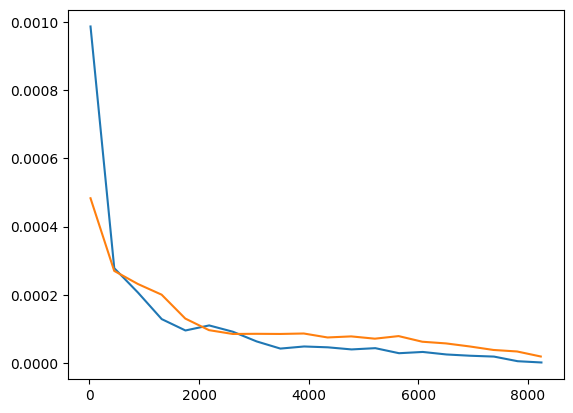

In [29]:
# not_churned = contract[contract['EndDate'] == 0]
# churned = contract[contract['EndDate'] == 1]


def hist(x):
    hist = np.histogram(x, bins=20, density=True)
    plt.plot(hist[1][:-1],hist[0])
    
hist(cancelations['TotalCharges'])
hist(customers['TotalCharges'])

In [30]:
customers['MonthlyCharges'].mean()

61.26512369540008

In [31]:
customers['MonthlyCharges'].describe()

count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [32]:
cancelations['MonthlyCharges'].mean()

74.44133226324237

In [33]:
cancelations['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

###### **Finding #4: Canceled customers have greater monthly charges than the typical Interconnect customer**
###### - **Canceled customers on average pay \$13 more per month than current customers, an almost 22% increase**
###### - **The first quartile of canceled customers pay significantly more than current customers, as canceled customers at the 25th percentile paid $31 more than current customers, and had monthly charges more than double the average loyal customer**
###### - **The third quartile of canceled customers paid ~\$6 more than current customers on average in monthly charges**

In [34]:
print("\n")

##### Exploring the Relationship between Total Charges and Cancelations

In [35]:
customers['TotalCharges'].describe()

count    5174.000000
mean     2552.882494
std      2327.590132
min        18.800000
25%       579.575000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: TotalCharges, dtype: float64

In [36]:
cancelations['TotalCharges'].describe()

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: TotalCharges, dtype: float64

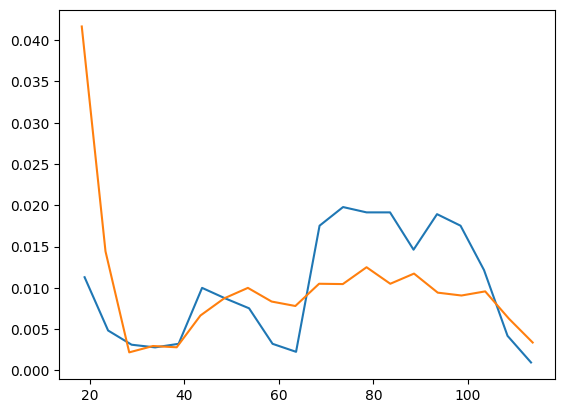

In [37]:
def hist(x):
    hist = np.histogram(x, bins=20, density=True)
    plt.plot(hist[1][:-1],hist[0])
    
hist(cancelations['MonthlyCharges'])
hist(customers['MonthlyCharges'])

The total charges column appears to be a running sum of all the monthly charges accrued by customers. Because canceled customers are no longer subscribed to Interconnect, it stands to reason that current customers would have greater total charges than canceled customers, with a mean of $1,670, more than double that of canceled customers. 

###### **Finding #5: Canceled customers have much smaller total charges than the typical Interconnect customer, bring in less than half the revenue of current customers, and are a major source of revenue leakage for the company** 

In [38]:
print("\n")

## Step 2

Exploring the effect of demographic information such as gender, Senior Citizen status, relationship status, and dependents on customer churn and loyalty.

##### Exploring the role of gender in customer loyalty

In [39]:
#Merging the personal df containing demographic info to the contract df to identify current and canceled customers
merged_df = personal.merge(contract, on='customerID', how='left')

In [40]:
merged_df

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,2017-04-01,0,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,0,One year,Yes,Mailed check,84.80,1990.50
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,0,One year,Yes,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,0,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,1,Month-to-month,Yes,Mailed check,74.40,306.60


In [41]:
customers = merged_df[merged_df['EndDate'] == 0]
cancelations = merged_df[merged_df['EndDate'] == 1]

In [42]:
customers['gender'].value_counts()

Male      2625
Female    2549
Name: gender, dtype: int64

In [43]:
cancelations['gender'].value_counts()

Female    939
Male      930
Name: gender, dtype: int64

51% of current customers are male and 49% are female, whereas with canceled customers, we see closer to a 50/50 split between males and females. There does not appear to be a correlation between gender and loyalty to Interconnect.  

###### **Finding #6: Gender does not appear to play a role in customer churn** 

In [44]:
print("\n")

##### Exploring the role of Senior Citizen status on customer loyalty

In [45]:
customers['SeniorCitizen'].value_counts()

0    4508
1     666
Name: SeniorCitizen, dtype: int64

In [46]:
cancelations['SeniorCitizen'].value_counts()

0    1393
1     476
Name: SeniorCitizen, dtype: int64

Around 13% of current customers are listed as Senior Citizens compared to over 25% for canceled customers. 

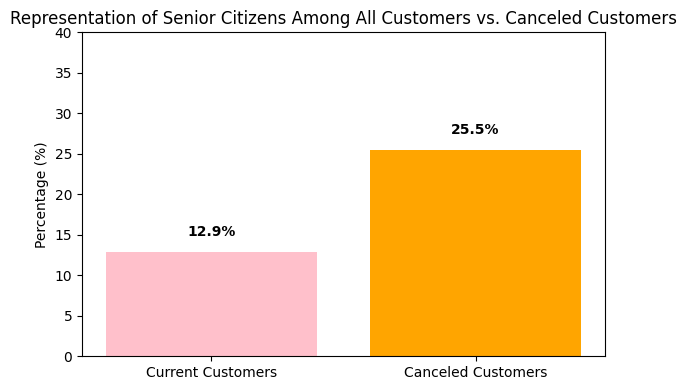

In [47]:
# % current customers who are Seniors
senior_customers = (customers['SeniorCitizen'] == 1).sum() / len(customers) * 100

# % cancelations that are Seniors
senior_canceled = (cancelations['SeniorCitizen'] == 1).sum() / len(cancelations) * 100

# Create chart
labels = ['Current Customers', 'Canceled Customers']
values = [senior_customers, senior_canceled]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['pink', 'orange'])
plt.ylabel('Percentage (%)')
plt.title('Representation of Senior Citizens Among All Customers vs. Canceled Customers')
plt.ylim(0, 40)

# Add percentage labels above bars
for i, val in enumerate(values):
    plt.text(i, val + 2, f"{val:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

###### **Finding #6: Seniors are overrepresented among canceled customers, with this group having around twice as many Seniors as current customers as a whole**

In [48]:
print("\n")

##### Exploring the role of Relationship Status on customer loyalty

In [49]:
customers['Partner'].value_counts()

Yes    2733
No     2441
Name: Partner, dtype: int64

In [50]:
cancelations['Partner'].value_counts()

No     1200
Yes     669
Name: Partner, dtype: int64

53% of current customers are listed as having partners compared to 36% of canceled customers. 

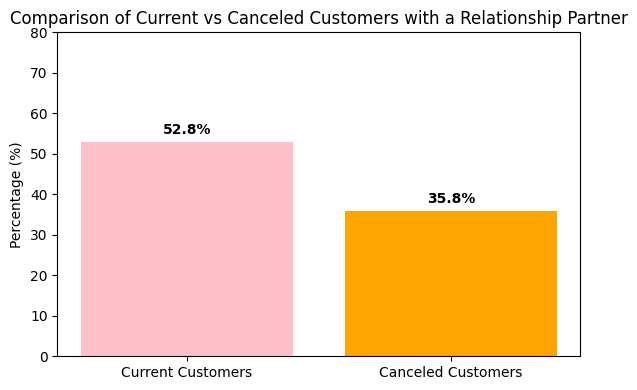

In [51]:
# % current customers who have a Partner
customer_partner = (customers['Partner'] == 'Yes').sum() / len(customers) * 100

# % cancelations that have a Partner
canceled_partner = (cancelations['Partner'] == 'Yes').sum() / len(cancelations) * 100

# Create chart
labels = ['Current Customers', 'Canceled Customers']
values = [customer_partner, canceled_partner]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['pink', 'orange'])
plt.ylabel('Percentage (%)')
plt.title('Comparison of Current vs Canceled Customers with a Relationship Partner')
plt.ylim(0, 80)

# Add percentage labels above bars
for i, val in enumerate(values):
    plt.text(i, val + 2, f"{val:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

###### **Finding #7: Canceled customers have 1/3 fewer partners than our group of current customers**

In [52]:
print("\n")

##### Exploring the role of dependents on customer loyalty

In [53]:
customers['Dependents'].value_counts()

No     3390
Yes    1784
Name: Dependents, dtype: int64

In [54]:
cancelations['Dependents'].value_counts()

No     1543
Yes     326
Name: Dependents, dtype: int64

34% of current customers have dependents vs 17% of canceled customers

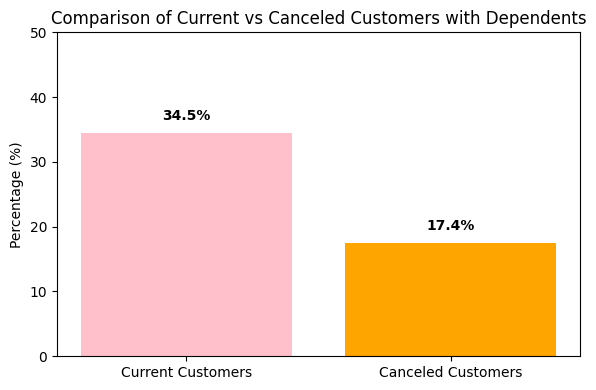

In [55]:
# % current customers who have a Partner
customer_deps = (customers['Dependents'] == 'Yes').sum() / len(customers) * 100

# % cancelations that have a Partner
canceled_deps = (cancelations['Dependents'] == 'Yes').sum() / len(cancelations) * 100

# Create chart
labels = ['Current Customers', 'Canceled Customers']
values = [customer_deps, canceled_deps]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['pink', 'orange'])
plt.ylabel('Percentage (%)')
plt.title('Comparison of Current vs Canceled Customers with Dependents')
plt.ylim(0, 50)

# Add percentage labels above bars
for i, val in enumerate(values):
    plt.text(i, val + 2, f"{val:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

###### **Finding #8: Canceled customers are half as likely as current customers to have dependents**

In [56]:
print("\n")

## Step 3

Exploring the effect of type of internet service and add-ons, as well as subscription to multiple phone lines, on customer churn and loyalty.

In [57]:
#Merging the merged df with the internet df identify internet plans of current and canceled customers
new_df = merged_df.merge(internet, on='customerID', how='left')

In [58]:
new_df

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,0,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,0,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,0,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,1,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No


In [59]:
customers = new_df[merged_df['EndDate'] == 0]
cancelations = new_df[merged_df['EndDate'] == 1]

In [60]:
customers

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,0,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,Female,0,No,No,2019-04-01,0,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,2569-WGERO,Female,0,No,No,2014-02-01,0,Two year,Yes,Bank transfer (automatic),21.15,1419.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,0,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,0,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,0,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No


In [61]:
cancelations

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2,3668-QPYBK,Male,0,No,No,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Female,0,No,No,2019-03-01,1,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes
8,7892-POOKP,Female,0,Yes,No,2017-07-01,1,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes
13,0280-XJGEX,Male,0,No,No,2015-09-01,1,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Fiber optic,No,Yes,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1699-HPSBG,Male,0,No,No,2018-11-01,1,One year,Yes,Electronic check,59.80,727.80,DSL,No,No,No,Yes,Yes,No
7026,8775-CEBBJ,Female,0,No,No,2019-02-01,1,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,DSL,No,No,No,No,No,No
7032,6894-LFHLY,Male,1,No,No,2019-10-01,1,Month-to-month,Yes,Electronic check,75.75,75.75,Fiber optic,No,No,No,No,No,No
7034,0639-TSIQW,Female,0,No,No,2014-03-01,1,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,Fiber optic,Yes,Yes,Yes,No,Yes,No


##### Exploring the effect of type of Internet service on customer loyalty

In [62]:
customers['InternetService'].value_counts()

DSL            1962
Fiber optic    1799
Name: InternetService, dtype: int64

In [63]:
cancelations['InternetService'].value_counts()

Fiber optic    1297
DSL             459
Name: InternetService, dtype: int64

48% of current Interconnect Internet customers are on Fiber optic service, whereas this number is 74% for canceled customers.   

###### **Finding #9: Canceled customers subscribed to fiber optic internet at rates that were 54% greater than those of current customers. The fiber optic service appears to be unsatisfactory in either experience or price as 94% of all canceled customers subscribed to internet service, with 74% of them having subscribed to fiber optic internet before leaving**

In [64]:
print("\n")

##### Exploring the effect of Internet add-ons on customer loyalty

In [65]:
customers['OnlineSecurity'].value_counts()

No     2037
Yes    1724
Name: OnlineSecurity, dtype: int64

In [66]:
cancelations['OnlineSecurity'].value_counts()

No     1461
Yes     295
Name: OnlineSecurity, dtype: int64

46% of current customers opted for Online Security vs less than 17% of canceled customers. 

In [67]:
customers['OnlineBackup'].value_counts()

Yes    1906
No     1855
Name: OnlineBackup, dtype: int64

In [68]:
cancelations['OnlineBackup'].value_counts()

No     1233
Yes     523
Name: OnlineBackup, dtype: int64

51% of current customers opted for online backups vs 30% of canceled customers. 

In [69]:
customers['DeviceProtection'].value_counts()

No     1884
Yes    1877
Name: DeviceProtection, dtype: int64

In [70]:
cancelations['DeviceProtection'].value_counts()

No     1211
Yes     545
Name: DeviceProtection, dtype: int64

50% of current customers signed up for Device protection vs 31% of canceled customers.

In [71]:
customers['TechSupport'].value_counts()

No     2027
Yes    1734
Name: TechSupport, dtype: int64

In [72]:
cancelations['TechSupport'].value_counts()

No     1446
Yes     310
Name: TechSupport, dtype: int64

46% of current customers opted for tech support vs 18% of canceled customers. 

In [73]:
customers['StreamingTV'].value_counts()

Yes    1893
No     1868
Name: StreamingTV, dtype: int64

In [74]:
cancelations['StreamingTV'].value_counts()

No     942
Yes    814
Name: StreamingTV, dtype: int64

49% of both current and canceled customers opted for Streaming TV service from Interconnect.

In [75]:
customers['StreamingMovies'].value_counts()

Yes    1914
No     1847
Name: StreamingMovies, dtype: int64

In [76]:
cancelations['StreamingMovies'].value_counts()

No     938
Yes    818
Name: StreamingMovies, dtype: int64

~49% of both current and canceled customers signed up for Streaming Movie services. 

###### **Finding #10: Canceled customers are far less likely to subscribe to online security, backups, device protection, and tech support than current customers. Canceled customers subscribe to streaming TV and movies at nearly identical rates.**

In [77]:
print("\n")

##### Exploring the effect of multiple phone lines on customer loyalty

In [78]:
newer_df = new_df.merge(phone, on='customerID', how='left')

In [79]:
newer_df

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,0,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,0,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,0,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,1,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Yes


In [80]:
customers = newer_df[merged_df['EndDate'] == 0]
cancelations = newer_df[merged_df['EndDate'] == 1]

In [81]:
customers['MultipleLines'].value_counts()

No     2541
Yes    2121
Name: MultipleLines, dtype: int64

In [82]:
cancelations['MultipleLines'].value_counts()

Yes    850
No     849
Name: MultipleLines, dtype: int64

45% of current customers are on multiple phone lines vs. 50% of canceled customers.

###### Finding #11: the presence of multiple phone lines does not appear to be correlated to churn, with current and canceled customers signing up for multiple phone lines at similar rates. 

In [83]:
print("\n")

## Step 4

We will test different classification models using evaluation metrics such as AUC-ROC to identify models that can best predict churn. Before we do this, we must encode categorical features, drop columns that are not required, and split the data into training, validation, and test sets.

##### Encoding categorical features so that models can better predict churn

In [84]:
newer_df

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,0,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,1,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,0,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,1,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,0,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,0,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,0,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,1,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Yes


In [85]:
# Create a list of columns to be converted
categorical_data = ['gender', 'Partner','Dependents', 'Type','PaperlessBilling','PaymentMethod', 'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']

# Convert categorical data to numerical using OHE
df_ohe = pd.get_dummies(newer_df, columns=categorical_data, drop_first=False)

# Print sample of encoded data frame
df_ohe.head()

,customerID,SeniorCitizen,BeginDate,EndDate,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,...,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes
0,7590-VHVEG,0,2020-01-01,0,29.85,29.85,1,0,0,1,...,1,0,1,0,1,0,1,0,0,0
1,5575-GNVDE,0,2017-04-01,0,56.95,1889.50,0,1,1,0,...,0,1,1,0,1,0,1,0,1,0
2,3668-QPYBK,0,2019-10-01,1,53.85,108.15,0,1,1,0,...,1,0,1,0,1,0,1,0,1,0
3,7795-CFOCW,0,2016-05-01,0,42.30,1840.75,0,1,1,0,...,0,1,0,1,1,0,1,0,0,0
4,9237-HQITU,0,2019-09-01,1,70.70,151.65,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0


Our categorical features have been successfully encoded.  

##### Dropping columns not required for our models

In [86]:
# fields we will be dropping
drop_fields = ['customerID','BeginDate']

# Create list of fields to drop
df = df_ohe.drop(columns=drop_fields)

# Check that fields were dropped
df.head()

,SeniorCitizen,EndDate,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes
0,0,0,29.85,29.85,1,0,0,1,1,0,...,1,0,1,0,1,0,1,0,0,0
1,0,0,56.95,1889.50,0,1,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
2,0,1,53.85,108.15,0,1,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
3,0,0,42.30,1840.75,0,1,1,0,1,0,...,0,1,0,1,1,0,1,0,0,0
4,0,1,70.70,151.65,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0


##### Splitting our data into validation, test, and training sets

In [87]:
# We will split our data so that 60% is in training, 20% in validation and 20% in test sets (3:1:1)
training_set, validation_split = train_test_split(df, test_size=0.40, random_state=12345)

# Split validation_split in half for validation & test sets
validation_set, test_set = train_test_split(validation_split, test_size=0.50, random_state=12345)

# Create the features and target training datasets
features_train = training_set.drop(['EndDate'], axis=1)
target_train = training_set['EndDate']

# Create the features and target validation datasets
features_valid = validation_set.drop(['EndDate'], axis=1)
target_valid = validation_set['EndDate']

# Create the features and target test datasets
features_test = test_set.drop(['EndDate'], axis=1)
target_test = test_set['EndDate']

#Training 
print(features_train.shape) # Training set contains 60% of original dataframe rows 
print(target_train.shape)   # Training set contains 60% of original dataframe rows 

# Validation
print(features_valid.shape) # Validation set contains 25% of original dataframe rows 
print(target_valid.shape)   # Validation set contains 25% of original dataframe rows 

# Test
print(features_test.shape)  # Test set contains 25% of original dataframe rows 
print(target_test.shape)    # Test set contains 25% of original dataframe rows 

(4225, 34)
(4225,)
(1409, 34)
(1409,)
(1409, 34)
(1409,)


#### Dummy Classifier

In [88]:
%%time

# Create a baseline random classifier
model = DummyClassifier(strategy='stratified', random_state=1234)

# Fit the classifier on the training data
model.fit(features_train, target_train)

# Make predictions on the validation features
prediction_test = model.predict(features_test)

# Calculate accuracy and other metrics
accuracy = accuracy_score(target_test, prediction_test)
report = classification_report(target_valid, prediction_test)

# Calculate and Print AUC_ROC Score
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('The AUC_ROC Score is on Validation Set:',round(auc_roc,3))

# Print the results
print("Accuracy on Validation Set:", round(accuracy,3))
print()

print("Classification Report:")
print(report)

The AUC_ROC Score is on Validation Set: 0.488
Accuracy on Validation Set: 0.595

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1027
           1       0.30      0.30      0.30       382

    accuracy                           0.62      1409
   macro avg       0.52      0.52      0.52      1409
weighted avg       0.62      0.62      0.62      1409

CPU times: user 5.62 ms, sys: 691 µs, total: 6.31 ms
Wall time: 5.7 ms


This dummy classifier will be used as a baseline to assess the performance of our models. It uses the stratified strategy, meaning this dummy model will preserve the class distribution of our training set, and will predict roughly 26.5% of our training set customers to churn.

#### Logistic Regression

In [89]:
%%time

# Create a LogisticRegression Model
model = LogisticRegression(random_state=12345, solver="liblinear")

# Fit the model to the traning dataset
model.fit(features_train, target_train)

# Make predictions on the validation features
prediction_valid = model.predict(features_valid)

# Calculate accuracy and other metrics
accuracy = accuracy_score(target_valid, prediction_valid)
report = classification_report(target_valid, prediction_valid)

# Calculate and Print AUC_ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC_ROC Score is on Validation Set:',round(auc_roc,3))

# Print the results
print("Accuracy on Validation Set:", round(accuracy,3))
print()

print("Classification Report:")
print(report)

The AUC_ROC Score is on Validation Set: 0.847
Accuracy on Validation Set: 0.803

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1027
           1       0.67      0.54      0.60       382

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

CPU times: user 21.1 ms, sys: 53.8 ms, total: 74.9 ms
Wall time: 25 ms


Our Logistic Regression model produces an AUC-ROC of 0.847. This is a hair under the 0.85 that Interconnect has tasked us with achieving. 

#### Random Forest

In [105]:
%%time

# Create a LogisticRegression Model
model = RandomForestClassifier(random_state=12345)

# Fit the model to the traning dataset
model.fit(features_train, target_train)

# Make predictions on the validation features
prediction_valid = model.predict(features_valid)

# Calculate accuracy and other metrics
accuracy = accuracy_score(target_valid, prediction_valid)
report = classification_report(target_valid, prediction_valid)

# Calculate and Print AUC_ROC Score
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('The AUC_ROC Score on Validation Set is:',round(auc_roc,3))

# Print the results
print("Accuracy on Validation Set:", round(accuracy,3))
print()

print("Classification Report:")
print(report)

The AUC_ROC Score on Validation Set is: 0.823
Accuracy on Validation Set: 0.787

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1027
           1       0.64      0.50      0.56       382

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

CPU times: user 374 ms, sys: 3.78 ms, total: 377 ms
Wall time: 376 ms


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> I recommend using parameter tuning to get the best RF model. 
<a class="tocSkip"></a>

Our Random Forest model performed slightly worse than Logistic Regression, with an AUC-ROC score of 0.823 on the validation set.

In [91]:
# %%time

# # Set variables to LGBMClassifier
# model = LGBMClassifier(random_state=12345)

# # Fit the model to the traning dataset
# model.fit(features_train, target_train)

# # Make predictions on the validation features
# prediction_valid = model.predict(features_valid)

# # Calculate accuracy and other metrics
# accuracy = accuracy_score(target_valid, prediction_valid)
# report = classification_report(target_valid, prediction_valid)

# # Calculate and Print AUC_ROC Score
# probabilities_valid = model.predict_proba(features_valid)
# probabilities_one_valid = probabilities_valid[:, 1]
# auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
# print('The AUC_ROC Score is on Validation Set:',round(auc_roc,3))

# # Print the results
# print("Accuracy on Validation Set:", round(accuracy,3))
# print()

# print("Classification Report:")
# print(report)

#### LGBM Classification

In [104]:
lgb_params = {
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.05, 0.1]
}

lgb_grid = GridSearchCV(LGBMClassifier(random_state=12345), lgb_params,
                        scoring='roc_auc', cv=4, n_jobs=-1)
lgb_grid.fit(features_train, target_train)
lgb_best = lgb_grid.best_estimator_
lgb_pred = lgb_best.predict(features_valid)
probabilities_valid = lgb_grid.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('The AUC_ROC Score on Validation Set is:',round(auc_roc,3))
# print(f"LGBMClassifier AUC-ROC: {scoring:.4f}")
print("Best Params:", lgb_best)

The AUC_ROC Score on Validation Set is: 0.85
Best Params: LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=50,
               random_state=12345)


In [109]:
# xgb_params = {
#     'n_estimators': [25, 50, 75, 100],
#     'max_depth': [5, 10, 15, 20],
#     'learning_rate': [0.05, 0.1]
# }

# # Set up GridSearchCV
# xgb_grid = GridSearchCV(XGBClassifier(random_state=12345, verbosity=0), 
#                         xgb_params, 
#                         scoring='roc_auc')

# # Fit to training data
# xgb_grid.fit(features_train, target_train)

# # Make predictions on the validation set
# prediction_valid = xgb_grid.predict(features_valid)

# # Calculate accuracy and classification report
# accuracy = accuracy_score(target_valid, prediction_valid)
# report = classification_report(target_valid, prediction_valid)

# # Calculate AUC-ROC score using probabilities from the best estimator
# probabilities_valid = xgb_grid.best_estimator_.predict_proba(features_valid)[:, 1]
# auc_roc = roc_auc_score(target_valid, probabilities_valid)

# # Print results
# print('The AUC-ROC Score on Validation Set is:', round(auc_roc, 3))
# print("Accuracy on Validation Set:", round(accuracy, 3))
# print("\nClassification Report:\n", report)

/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClas

KeyboardInterrupt: 

We have achieved an AUC_ROC of 0.85 using our LGBMClassifier model. 

### Model Evaluation on Test Set

In [ ]:
model = LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=50,
               random_state=12345)

In [110]:
model.fit(features_train, target_train)

# Predict target values on the test set
predicted_values = model.predict(features_test)

# Calculate and Print AUC_ROC Score
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

# Calculate accuracy between predicted target and actual target for validation set
accuracy = accuracy_score(target_test, predicted_values)

# Print results of tuning and AUC_ROC & Accuracy on test set 
print("The AUC_ROC  of the best XGBClassifier model on the Test Set:", round(auc_roc,3))
print("The Accuracy of the best XGBClassifier model on the Test Set:",round(accuracy,3))

The AUC_ROC Using the Tuned XGBClassifier model on the Test Set: 0.791
The Accuracy Using the Tuned XGBClassifier model on the Test Set: 0.775


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> While I would have recommended using parameter tuning on other models, this looks like a good solution
<a class="tocSkip"></a>